<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/BERT/BERTimbau_com_amostras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install transformers

     |████████████████████████████████| 2.6 MB 7.3 MB/s 
     |████████████████████████████████| 3.3 MB 42.3 MB/s 
     |████████████████████████████████| 895 kB 63.3 MB/s 
     |████████████████████████████████| 636 kB 53.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:

!pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.


     |████████████████████████████████| 804.1 MB 2.7 kB/s 
     |████████████████████████████████| 17.4 MB 108 kB/s 
     |████████████████████████████████| 1.9 MB 43.7 MB/s 
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==1.8.1, torchaudio==0.8.0 and torchvision==0.9.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==1.8.1
    torchvision 0.9.1 depends on torch==1.8.1
    torchaudio 0.8.0 depends on torch==1.8.0

To fix this you could try to:
1. loosen the range of package versions you'

In [4]:
!nvidia-smi

Tue Aug 10 11:02:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from datetime import datetime
from google.colab import files, drive
import io, os

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

### Carregando tokens e vocabulário do BERTimbau

In [6]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='neuralmind/bert-base-portuguese-cased', vocab_size=29794, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

### Preparando DataSet
https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

In [7]:
#!rm *.csv
#!!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/train.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/valid.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/test.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/miscelanea.csv
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks
path = '/gdrive/My Drive/Colab Notebooks'
KEY='4/1AX4XfWjFfXOpQF_Lhhwz8Sp5DTauJAEXNDQjx66Khyme5ASsCvDLtcqsBX0'

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


In [ ]:
#%cd amostra_news_integrada
#!unzip drive-download-20210731T211249Z-001.zip
#!ls -lh

#!mkdir bertimbau_all_categ


In [ ]:
#!mkdir ./bertimbau_all_categ/amostra_4


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
source_folder = './amostra_news_integrada/amostra_' #'/content'
destination_folder = './bertimbau_resp' #'/content'


In [11]:
!ls 

 amostra_news_integrada		       'Cópia de BERTimbau_Testes (3).ipynb'
 artigosWikibr.ipynb		       'Cópia de BERTimbau_Testes.ipynb'
 BERTimbau_com_amostras.ipynb	        news_integradas.csv
 bertimbau_resp			        Untitled
'Cópia de BERTimbau_Testes (1).ipynb'   Untitled1.ipynb
'Cópia de BERTimbau_Testes (2).ipynb'


In [12]:
#https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
#Model hyper-parameter
MAX_SEQ_LEN = 128 #limita os artigos em 128 tokens. Bert é limitado em 512 tokens por texto (checar isto e aplicar limpeza nos textos).
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
bs = 16
lr = 1e-6



# Fields - use_vocab=False  e tokenizer.encode permite que utilizemos os tokens do BERTimbau.
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field),('label', label_field)]





In [13]:
def tokenizaAmostra(source_folder, fields=fields):
  # TabularDataset
  train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                            test='test.csv', format='CSV', fields=fields, skip_header=True)
  # Iterators

  train_iter = BucketIterator(train, batch_size=bs, sort_key=lambda x: len(x.text),
                              device=device, train=True, sort=True, sort_within_batch=True)
  valid_iter = BucketIterator(valid, batch_size=bs, sort_key=lambda x: len(x.text),
                              device=device, train=True, sort=True, sort_within_batch=True)
  test_iter = Iterator(test, batch_size=bs, device=device, train=False, shuffle=False, sort=False)
  return [train_iter, valid_iter, test_iter]



In [ ]:
#print(vars(train[0]))
#print(vars(valid[0]))
#print(vars(test[0]))

## Modelo

In [14]:
'''É preciso informar o número de labels '''
class BERT(nn.Module):

    def __init__(self, qtd_categories):
        super(BERT, self).__init__()

        options_name = "bert-base-portuguese-cased"
        self.encoder = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased',num_labels=qtd_categories )

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea



## Treinamento

In [15]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

def create_directory(path, directory):
  try:
    os.makedirs(path + '/' + directory)
  except FileExistsError:
    # directory already exists
    pass

In [14]:
# Training Function
'''criterion = nn.BCELoss() é BinaryCrossEntropy é a função de perda para targets binarios. Como o nosso alvo possui
muitas classes troque a função de perda para nn.CrossEntropyLoss() '''

def train(model,
          optimizer,
          train_loader ,
          valid_loader ,
          eval_every ,
          file_path ,
          criterion = nn.CrossEntropyLoss(), #nn.BCELoss(),
          num_epochs = 5,
          best_valid_loss = float("Inf")):
    
    
    print('1 - inicializando variávies')
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    print('1 - inicializando treinamento')
    model.train()
    for epoch in range(num_epochs):
        for (text, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            #print('label size:', labels.size())
            #print('label:', labels)
            labels = labels.to(device)
            text = text.type(torch.LongTensor) 
            #print('text:', text.size())
            text = text.to(device)
            #print('treina...')
            output = model(text, labels)
            #print('fim treino...')
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text,labels), _ in valid_loader:
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    

In [15]:
device

device(type='cuda', index=0)

In [29]:
%%time
qtd_categories=[18]
#token_train, token_valid, token_test = [],[],[]
id_planilha = [5]
dataset = [2]
for idx, (id_, amostra) in enumerate(zip(id_planilha,dataset)):
  create_directory(destination_folder,str(id_))
  file_path = destination_folder + "/"+str(id_)
  print(file_path)
  model = BERT(qtd_categories=qtd_categories[idx]).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  inicio = datetime.now()
  print('Treinando amostra:', amostra, 'inicio:', inicio)
  tokens = tokenizaAmostra(source_folder+str(amostra))
  #token_train.append(tokens[0])
  #token_valid.append(tokens[1])
  #token_test.append(tokens[2])
  train(model=model, 
      optimizer=optimizer,
      num_epochs=7,
      train_loader=tokens[0],
      valid_loader=tokens[1],
      eval_every=len(tokens[0]) // 2,
      file_path=file_path)
  print('Duracao:', datetime.now()-inicio)

./bertimbau_resp/5


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 2 inicio: 2021-08-10 02:06:42.178559
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/7], Step [450/6300], Train Loss: 2.8171, Valid Loss: 2.7566
Model saved to ==> ./bertimbau_resp/5/model.pt
Model saved to ==> ./bertimbau_resp/5/metrics.pt
Epoch [1/7], Step [900/6300], Train Loss: 2.6793, Valid Loss: 2.5110
Model saved to ==> ./bertimbau_resp/5/model.pt
Model saved to ==> ./bertimbau_resp/5/metrics.pt
Epoch [2/7], Step [1350/6300], Train Loss: 2.3808, Valid Loss: 2.2194
Model saved to ==> ./bertimbau_resp/5/model.pt
Model saved to ==> ./bertimbau_resp/5/metrics.pt
Epoch [2/7], Step [1800/6300], Train Loss: 2.1489, Valid Loss: 1.9142
Model saved to ==> ./bertimbau_resp/5/model.pt
Model saved to ==> ./bertimbau_resp/5/metrics.pt
Epoch [3/7], Step [2250/6300], Train Loss: 1.8101, Valid Loss: 1.6444
Model saved to ==> ./bertimbau_resp/5/model.pt
Model saved to ==> ./bertimbau_resp/5/metrics.pt
Epoch [3/7], Step [2700/6300], Train Loss: 1.6428, Valid L

In [ ]:
#!ls ./amostra_news_integrada/

#!rm  ./bertimbau_all_categ/amostra_4/*.*

!du -sh

Model loaded from <== ./bertimbau_resp/2/metrics.pt


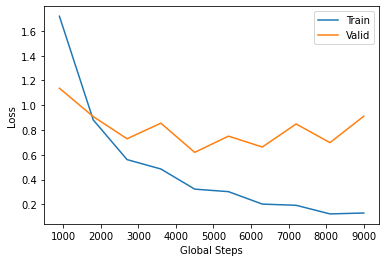

Model loaded from <== ./bertimbau_resp/4/metrics.pt


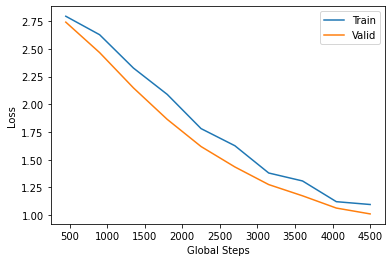

Model loaded from <== ./bertimbau_resp/5/metrics.pt


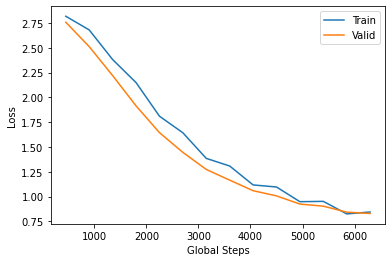

In [16]:
id_planilha = [2,4,5]
for id_ in id_planilha:
  file_path = destination_folder + "/"+str(id_)
  train_loss_list, valid_loss_list, global_steps_list = load_metrics(file_path + '/metrics.pt')
  plt.plot(global_steps_list, train_loss_list, label='Train')
  plt.plot(global_steps_list, valid_loss_list, label='Valid')
  plt.xlabel('Global Steps')
  plt.ylabel('Loss')
  plt.title = 'Resultado do Treino id ' + str(id_)
  plt.legend()
  plt.show() 

### Avaliação

In [17]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in test_loader:
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    n_classe = np.max(y_true)+1
    print(classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')



In [ ]:
#%%time    
qtd_categories=[18,18]
id_planilha = [4,5]
dataset = [2,2]
for idx, (id_, amostra) in enumerate(zip(id_planilha,dataset)):
      tokens = tokenizaAmostra(source_folder+str(amostra))
      best_model =BERT(qtd_categories=qtd_categories[idx]).to(device)
      load_checkpoint(destination_folder+"/"+str(id_) + '/model.pt', best_model)
      evaluate(best_model, tokens[2])

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/4/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.7449    0.7449    0.7449        98
           1     0.7000    0.0787    0.1414        89
           2     0.6387    0.8000    0.7103        95
           3     0.8537    0.9545    0.9013       110
           4     0.7143    0.7812    0.7463        96
           5     0.7391    0.7010    0.7196        97
           6     0.7766    0.6518    0.7087       112
           7     0.7525    0.7308    0.7415       104
           8     0.7966    0.5165    0.6267        91
           9     0.6145    0.5368    0.5730        95
          10     0.9314    0.9314    0.9314       102
          11     0.8315    0.8506    0.8409        87
          12     0.8992    0.9386    0.9185       114
          13     0.6783    0.8584    0.7578       113
          14     0.7909    0.9062    0.8447        96
          15     0.5760    0.8090    0.6729        89
        

In [ ]:
#!rm ./bertimbau_all_categ/amostra_4/*.*
#!du -sh
